

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)).


##Libraries

In [1]:
import gym
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random

## Hyperparameters

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 100000
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 400
MAX_STEPS = 1000
USE_TARGET = True

## Class ReplayMemory

Memory of transitions for experience replay.

In [3]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [7]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions, use_target=True):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.use_target = use_target
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        
    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)
        
        if self.use_target:
            q_targets = self.target_model.predict(states, verbose=0)
            q_next_states = self.target_model.predict(next_states, verbose=0)
        else:
            q_targets = self.model.predict(states, verbose=0)
            q_next_states = self.model.predict(next_states, verbose=0)

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")\
    
    def create_model(self):
        # Creates the models
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(24, input_shape=(number_of_observations,), \
                             activation="relu",kernel_initializer="he_normal"))
        model.add(keras.layers.Dense(24, activation="relu",kernel_initializer="he_normal"))
        model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model
    
    def update_target_model(self):
        if (use_target):
            print("Updating target model weights")
            self.target_model.set_weights(self.model.get_weights())
        
    def save_model(self, model_name):
        self.model.save(model_name)

## Environment Lunar Lander

Lunar Lander simulator from Open Ai Gym:

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: position
- state[1]: velocity
- state[2]: angle
- state[3]: angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

In [5]:
def create_environment(render=False):
    # Create simulated environment
    if render:
        environment = gym.make("LunarLander-v2", render_mode="human")
    else:
        environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Main program




We add episode score, the episode score will be equal to the sum of rewards in each step of the episode.

Updating target model weights
Episode   1: score -262.0404557856934 (exploration rate: 0.68, transitions: 107 time  13 )
Updating target model weights
Episode   2: score -146.14045765281676 (exploration rate: 0.48, transitions: 177 time  9 )
Updating target model weights
Episode   3: score -172.58574563078588 (exploration rate: 0.28, transitions: 284 time  15 )
Updating target model weights
Episode   4: score -329.08480704841384 (exploration rate: 0.10, transitions: 496 time  31 )
Updating target model weights
Episode   5: score -116.03927141902139 (exploration rate: 0.06, transitions: 582 time  14 )
Updating target model weights
Episode   6: score -121.94457922602619 (exploration rate: 0.05, transitions: 645 time  10 )
Updating target model weights
Episode   7: score -117.00996930401926 (exploration rate: 0.01, transitions: 1645 time  156 )
Updating target model weights
Episode   8: score -177.3099097691215 (exploration rate: 0.01, transitions: 2406 time  118 )
Updating target model w

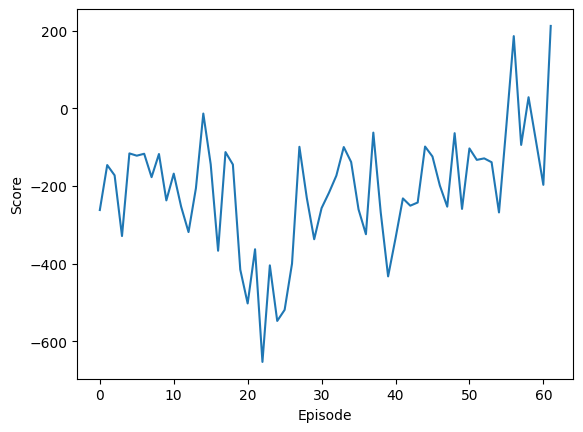

In [6]:
environment, number_of_observations, number_of_actions = create_environment(render=True)
agent = DQN(number_of_observations, number_of_actions)
episode = 0
goal_reached = False
start_time = time.perf_counter()
while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    start_episode_time = time.perf_counter()
    episode += 1
    episode_score = 0
    step = 1
    end_episode = False
    state = environment.reset()[0]
    
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state)
        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)
        
        # Update score:
        episode_score += reward
        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)

        # Learn using a batch of experience stored in memory
        agent.learn()
  
        # Detect end of episode and print
        if terminal_state or step >= MAX_STEPS:
            agent.add_score(episode_score)
            if episode_score >= 200: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(episode_score), end = '') 
            print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
            print("transitions:", str(agent.memory.current_size), end = ' ')
            print("time ", round(time.perf_counter() - start_episode_time), ")" )
            end_episode = True 
        else:
            state = state_next
            step += 1
            
    agent.update_target_model()
        
if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

print ("Time:", round((time.perf_counter() - start_time)/60), "minutes")

environment.close()
agent.display_scores_graphically()

In [ ]:
agent.save_model('model.hdf5')